<a href="https://colab.research.google.com/github/we-make-ai/welcome2ki-3/blob/main/08_Image_Presizing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
!pip install fastai --upgrade -q
!pip install -Uqq fastbook

In [56]:
import fastbook
fastbook.setup_book()

In [57]:
from fastbook import *
from fastai.vision.all import *

In [4]:
!wget https://cdn.pixabay.com/photo/2017/07/13/16/07/monkey-2500919_1280.jpg

--2020-11-19 08:21:26--  https://cdn.pixabay.com/photo/2017/07/13/16/07/monkey-2500919_1280.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.20.183, 104.18.21.183, 2606:4700::6812:14b7, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.20.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248507 (243K) [image/jpeg]
Saving to: ‘monkey-2500919_1280.jpg’

monkey-2500919_1280 100%[===================>] 242.68K  --.-KB/s    in 0.09s   

2020-11-19 08:21:27 (2.70 MB/s) - ‘monkey-2500919_1280.jpg’ saved [248507/248507]



# Vergleich fastai-Presizing vs. Standard Data Augmentation

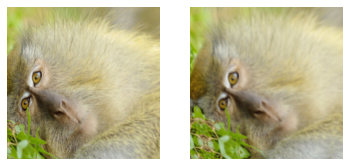

In [5]:
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
dls1 = dblock1.dataloaders([(Path.cwd()/'monkey-2500919_1280.jpg')]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

# Von Cats vs. Dogs zur Klassifikation von Hunderassen

In [58]:
path = untar_data(URLs.PETS)

In [59]:
Path.BASE_PATH = path

In [60]:
path.ls()

(#2) [Path('annotations'),Path('images')]

In [61]:
(path/"images").ls()

(#7393) [Path('images/Egyptian_Mau_12.jpg'),Path('images/Ragdoll_107.jpg'),Path('images/saint_bernard_181.jpg'),Path('images/Ragdoll_257.jpg'),Path('images/Abyssinian_152.jpg'),Path('images/Siamese_148.jpg'),Path('images/pug_39.jpg'),Path('images/Sphynx_58.jpg'),Path('images/Sphynx_198.jpg'),Path('images/Maine_Coon_137.jpg')...]

In [62]:
fname = (path/"images").ls()[0]

In [63]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['Egyptian_Mau']

In [64]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

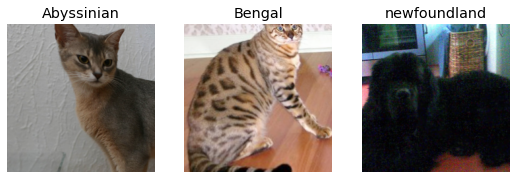

In [65]:
dls.show_batch(nrows=1, ncols=3)

In [14]:
#pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
#                 get_items=get_image_files, 
#                 splitter=RandomSplitter(seed=42),
#                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
#pets1.summary(path/"images")

In [66]:
pets.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Bengal_108.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x375
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Bengal_108.jpg
    applying partial gives
      Bengal
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(1)

Final sample: (PILImage mode=RGB size=500x375, TensorCategory(1))


Setting up after_item: Pipeline: Resize -- {'size': (460, 460), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch

In [16]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.498725,0.306279,0.098782,01:12


epoch,train_loss,valid_loss,error_rate,time
0,0.510122,0.283944,0.089310,01:18
1,0.345841,0.231958,0.068336,01:18


## Loss-Funktion: Cross Entropy Loss

**Charakteristika der Cross-Entropy-Loss-Function:**

* Funktioniert auch, wenn die abhängige Variable mehr als 2 mögliche Klassen aufweist --> Multi-Label-Classification
* Liefert ein schnelleres und exakteres Trainingsergebnis unseres neuronalen Netzes

In [17]:
x,y = dls.one_batch()

In [18]:
y

TensorCategory([10,  9, 14, 26,  2,  5, 28,  2,  3, 25,  8,  1, 35,  5, 35, 34, 10,  6, 15,  7,  6,  2, 23,  6,  7,  7,  5,  0,  2, 10, 31, 34, 13,  4, 15, 33,  6, 14, 27, 17,  6, 19, 32, 20, 17, 25, 34, 24,
        26, 36, 34, 10, 20,  5, 35, 16, 30, 36,  4, 15, 14,  1,  9, 32], device='cuda:0')

In [19]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

TensorImage([6.1950e-05, 1.6470e-06, 5.4347e-03, 3.8579e-03, 3.9570e-05, 8.9337e-06, 9.7577e-07, 1.0808e-05, 7.5766e-04, 8.0559e-03, 9.7919e-01, 2.2347e-05, 2.1101e-06, 1.1126e-07, 5.5744e-06, 9.9119e-07,
        1.2830e-05, 3.9050e-05, 2.4233e-06, 6.5742e-06, 1.1058e-05, 3.1491e-06, 2.7103e-07, 1.0535e-05, 2.1828e-05, 3.5777e-05, 2.2582e-05, 2.0215e-06, 3.5606e-06, 4.8140e-05, 8.7795e-07, 1.8173e-05,
        1.2136e-06, 2.2379e-03, 6.7555e-05, 8.0143e-07, 1.4522e-06])

In [20]:
preds[0].sum()

TensorImage(1.)

### Die "Softmax-Funktion"

/usr/local/lib/python3.6/dist-packages/fastbook/__init__.py:55: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


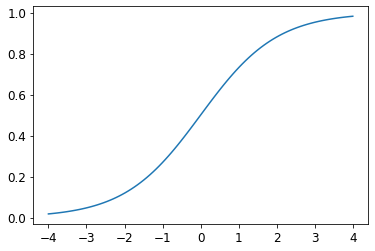

In [21]:
plot_function(torch.sigmoid, min=-4,max=4)

In [22]:
torch.random.manual_seed(42);

In [23]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [24]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [25]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

In [26]:
def softmax(x):
  return exp(x) / exp(x).sum(dim=1, keepdim=True)

In [27]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

### Log Likelihood

In [28]:
def mnist_loss(inputs, targets):
  inputs = inputs.sigmoid()
  return torch.where(targets==1, 1-inputs, inputs).mean()

In [29]:
targ = tensor([0,1,0,1,1,0])

In [30]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [31]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [32]:
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['loss'] = sm_acts[range(6), targ]

In [33]:
df

,3,7,targ,idx,loss
0,0.602469,0.397531,0,0,0.602469
1,0.502065,0.497935,1,1,0.497935
2,0.133188,0.866811,0,2,0.133188
3,0.996640,0.003360,1,3,0.003360
4,0.595949,0.404051,1,4,0.404051
5,0.366118,0.633882,0,5,0.366118


In [34]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

### NLL-Loss Berechnung des Logarithmus

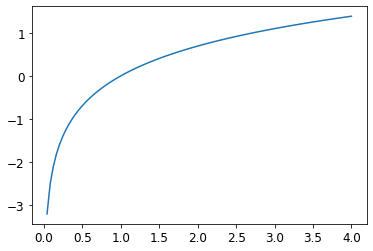

In [35]:
plot_function(torch.log, min=0,max=4)

y = b^a

a = log(y, b)

Die Logarithmusfunktion in Python berechnet den Logarithmus immer zur Basis der Euler Zahl e (2,718...)

log(a*b) = log(a)+log(b)


In [36]:
loss_func = nn.CrossEntropyLoss()

In [37]:
loss_func(acts, targ)

tensor(1.8045)

In [38]:
F.cross_entropy(acts, targ)

tensor(1.8045)

In [39]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

## Interpretation unseres Modells

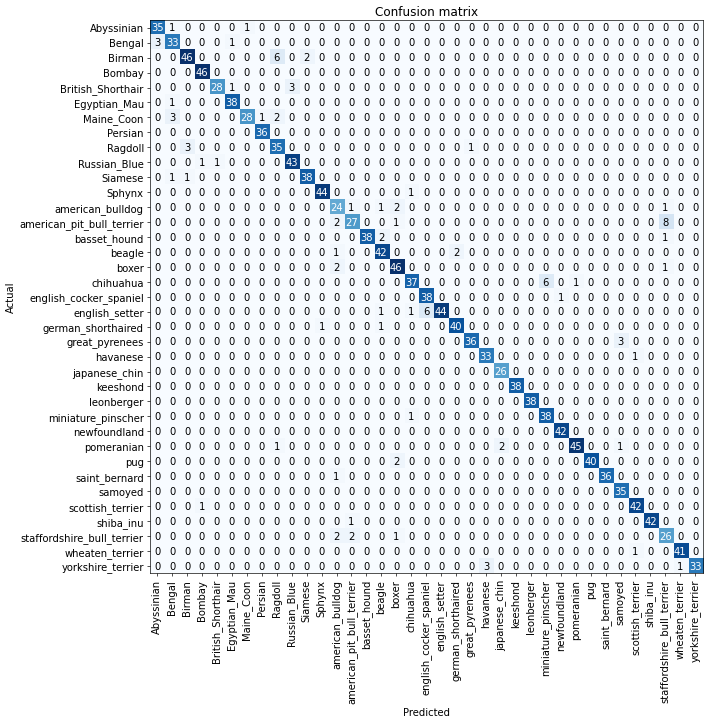

In [40]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [41]:
interp.most_confused(min_val=4)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 8),
 ('Birman', 'Ragdoll', 6),
 ('chihuahua', 'miniature_pinscher', 6),
 ('english_setter', 'english_cocker_spaniel', 6)]

## Verbesserung unseres Modells

### Learning Rate

In [42]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.905817,5.506740,0.543978,01:13


epoch,train_loss,valid_loss,error_rate,time
0,4.535483,3.459284,0.877537,01:18


In [43]:
??learn.fine_tune

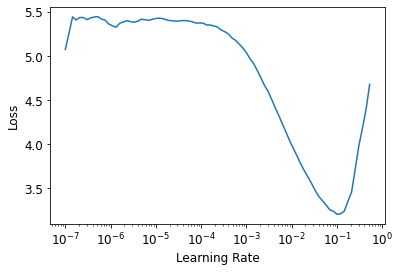

In [44]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

In [45]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 7.59e-03


In [46]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.334761,0.347545,0.112314,01:13


epoch,train_loss,valid_loss,error_rate,time
0,0.556621,0.407269,0.115697,01:18
1,0.355107,0.241786,0.078484,01:18


### Fine Tuning und Freezing

In [47]:
learn.fine_tune??

In [48]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.135120,0.334082,0.098106,01:13
1,0.538427,0.270402,0.090663,01:14
2,0.333958,0.208176,0.064276,01:13


In [49]:
learn.unfreeze()

In [54]:
??learn.unfreeze()

SuggestedLRs(lr_min=2.511886486900039e-06, lr_steep=1.5848931980144698e-06)

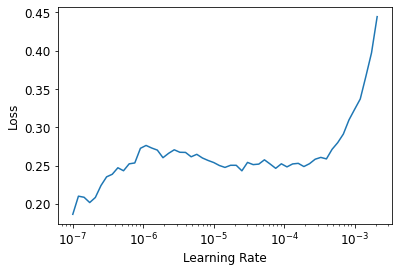

In [50]:
learn.lr_find()

In [51]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.252451,0.197433,0.057510,01:18
1,0.240958,0.197040,0.057510,01:18
2,0.215719,0.191735,0.056834,01:18
3,0.212561,0.187889,0.058863,01:18
4,0.198642,0.187269,0.056834,01:18
5,0.188562,0.183702,0.056157,01:18


#### Discriminative Learning Rates

In [52]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.151873,0.322531,0.107578,01:12
1,0.532188,0.235879,0.078484,01:13
2,0.343082,0.210835,0.069689,01:13


epoch,train_loss,valid_loss,error_rate,time
0,0.248320,0.201757,0.066982,01:18
1,0.242090,0.190025,0.062923,01:18
2,0.240920,0.190088,0.060893,01:18
3,0.217622,0.182209,0.060893,01:18
4,0.193088,0.175771,0.055480,01:18
5,0.163094,0.175347,0.056157,01:18
6,0.153934,0.173056,0.052097,01:18
7,0.148340,0.171281,0.051421,01:18
8,0.142161,0.172550,0.052774,01:18
9,0.130977,0.172407,0.047361,01:18


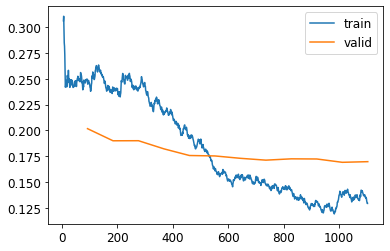

In [53]:
learn.recorder.plot_loss()

### Anzahl an Training Epochs

In [67]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.418301,0.310235,0.104871,01:34
1,0.587447,0.301882,0.103518,01:35
2,0.438889,0.273974,0.086604,01:35


epoch,train_loss,valid_loss,error_rate,time
0,0.273286,0.240572,0.075101,01:51
1,0.297027,0.281016,0.087957,01:51
2,0.248254,0.287771,0.087957,01:51
3,0.146553,0.221314,0.063599,01:51
4,0.092501,0.202008,0.054804,01:51
5,0.057940,0.191767,0.046685,01:51
